# Predicting NBA Players' Salary Through Linear Regression Model

#### Weon Gyu Jeon

## 1. Introduction

When I watch NBA offseason, I always think that some players are under/overpaid. Obviously, there are a lot of factors when it comes to the salary of players. stats, scale of the market, popularity of a player, even wealthiness of the owner. It also includes some factors that can't be numerically defined. In this project, I focused only on players' **traditional stats for current season (2024-2025)** to try predicting player's salary for next season.

## 2. Preparation

### 2.1 Packages & Libraries

In [207]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

### 2.2 Data Preparation
CSV for player salary in 2024-25 season was scrapped from [Basketball Reference](https://www.basketball-reference.com/contracts/players.html).
CSV for player stats can be easily acquired from [Basketball Reference](https://www.basketball-reference.com/leagues/NBA_2025_per_game.html) too.

In [209]:
salarydf = pd.read_csv("NBA Player Salaries_2024-25_1.csv")
statsdf = pd.read_csv("NBA Player Stats_2024-25_Per_Game.csv")

#### 2.2.1 Data Component
Here is how the data looks like, before cleaning.

In [211]:
pd.set_option('display.max_columns', None)
statsdf.head(1)

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Shai Gilgeous-Alexander,26,OKC,PG,76,76,34.2,11.3,21.8,0.519,2.1,5.7,0.375,9.2,16.1,0.571,0.569,7.9,8.8,0.898,0.9,4.1,5.0,6.4,1.7,1.0,2.4,2.2,32.7


In [212]:
salarydf.head(1)

,Player,Team,Salary
0,Stephen Curry,GSW,"$55,761,216"


### 2.3 Data Cleaning

#### 2.3.1 Salary Data
So for Salary Data, I had to:
1) remove dollar signs from 'Salary' column and change data type to integer so that it's calculatable
2) strip whitespaces from 'Player' column if there is any
3) check null values
4) finally, drop duplicate rows, of course

In [215]:
salarydf['Salary'] = salarydf['Salary'].replace(r'[\$,]', '', regex=True).astype(int)

salarydf['Player'] = salarydf['Player'].str.strip()

# print(salarydf.isnull().sum())

salarydf = salarydf.drop_duplicates()

#### 2.3.2 Stats Data

For stats data, I had to deal with player entries who played for multiple teams this season. If a player moved teams once within the season, Basketball Reference's record puts three entries separate:
1) player's total stats recorded in both teams
2) stats recorded in the first team
3) stats recorded in the second team

e.g. Zach Lavine played for CHI and SAC this season, then there are three entries for him: 2TM, CHI, SAC

So I cleaned it by counting the number of entries that one player has, filtered it, and saved entries that has their full stats this season.

In [312]:
# Step 1: find players played for multiple teams
duplicate_players = statsdf['Player'].value_counts()
multi_team_players = duplicate_players[duplicate_players > 1].index

In [314]:
# Step 2: Separately filter players (multi and single)
multi_team_rows = statsdf[statsdf['Player'].isin(multi_team_players)]
single_team_rows = statsdf[~statsdf['Player'].isin(multi_team_players)]

In [316]:
# Step 3: Combine the single-team rows with the multi-team rows that we will keep (one row per player, only)
# Here, we're keeping the very first row for each player in multi_team_rows (the one with '2TM', '3TM', etc.)
summary_rows = multi_team_rows.drop_duplicates(subset='Player', keep='first')
cleaned_statsdf = pd.concat([single_team_rows, summary_rows], ignore_index=True)

Then,
1) removed 'Rk' column which doesn't contain any meaning
2) stripped whitespaces in player names
3) check for null values

In [219]:
cleaned_statsdf = cleaned_statsdf.drop(columns=['Rk'], errors='ignore')

cleaned_statsdf['Player'] = cleaned_statsdf['Player'].str.strip()

cleaned_statsdf = cleaned_statsdf.fillna(0)

### 2.4 Merging Datasets

In [221]:
stats_salary = pd.merge(cleaned_statsdf, salarydf[['Player', 'Salary']], on='Player', how='inner')

#### 2.4.1 Further cleaning

In [223]:
stats_salary = stats_salary.drop_duplicates()

stats_salary = stats_salary.reset_index(drop=True)

## 3. Correlation

In [225]:
numeric_df = stats_salary.select_dtypes(include='number')
salary_corr = numeric_df.corr()['Salary'].drop('Salary').sort_values(ascending=False)

Corrleation:
```
PTS: 0.746         FG: 0.737      FGA: 0.719      FT: 0.705
FTA: 0.688         2PA: 0.687      2P: 0.677      MP: 0.652       TOV: 0.643
AST: 0.621         GS: 0.614       DRB: 0.546     3P: 0.500       3PA: 0.499
TRB: 0.477         STL: 0.476      PF: 0.389      Age: 0.327      G: 0.288
FT%: 0.240         BLK: 0.236      ORB: 0.219     FG%: 0.156      3P%: 0.140
eFG%: 0.140        2P%: 0.098
```


### 3.1 Barplot

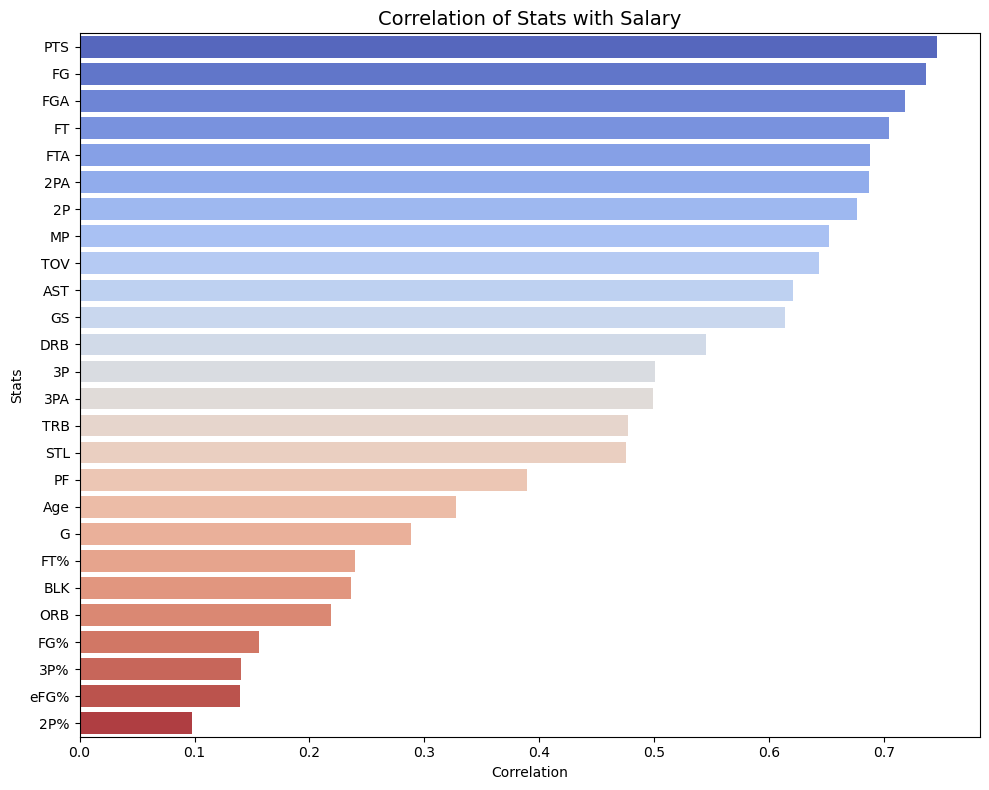

In [228]:
plt.figure(figsize=(10, 8))
sns.barplot(
    x=salary_corr.values,
    y=salary_corr.index,
    hue=salary_corr.index,
    palette="coolwarm",
    legend=False
)
plt.title("Correlation of Stats with Salary", fontsize=14)
plt.xlabel("Correlation")
plt.ylabel("Stats")
plt.tight_layout()
plt.show()

### 3.2 Scatterplots with some noticeable stats

I made column 'Salary_M' which just translates Salary to Million scale for convenience.

In [320]:
stats_salary['Salary_M'] = stats_salary['Salary'] / 1e6

In [230]:
def plot_salary_vs_stat(stat_col):
    fig = px.scatter(
        stats_salary,
        x='Salary_M',
        y=stat_col,    
        hover_data={
            'Player': True,
            stat_col: True,
            'Salary_M': ':.2f' 
        },
        trendline='ols',
        title=f'Salary vs {stat_col}', 
        labels={'Salary_M': 'Salary ($M)', stat_col: stat_col},
        trendline_color_override='black'
    )

    fig.update_traces(marker=dict(color='skyblue'))

    # Customize layout
    fig.update_layout(
        xaxis_tickprefix="$",
        xaxis_ticksuffix="M",
        template='plotly_white'
    )
    fig.show()

In [231]:
plot_salary_vs_stat('PTS')

plot_salary_vs_stat('MP')

plot_salary_vs_stat('Age')

In [232]:
if 'Salary_M' in stats_salary.columns:
    stats_salary = stats_salary.drop(columns=['Salary_M'])

### 3.3 Initial analysis of Correlation for building Regression Model

##### 1) Efficiency Stats (FT%, FG%, eFG%, 3P%, 2P%) show low correlation to player's salary
Potential reason for this is that efficiency stats often higher for role-players and bench players, who often doesn't get that many opportunity to score and specialized to one ability (e.g. spot-up shooters). So I dropped all of them except for eFG%, which shows low correlation to salary but combines both FG% and 3P%, which makes a comprehensive indicator for scoring efficiency.
##### 2) Will keep traditional (volume) stats, such as PTS, AST, TRB, STL, BLK
##### 3) Reducing Multicollinearity
1. FG-FGA, FT-FTA, 2P-2PA, 3P-3PA, ORB-DRB: Scoring stats are all diretly correlated to FG and ORB-DRB are directly correlated to TRB. I will remove all of them.
2. MP-G-GS: correlated to each other, displays player's actual involvement to the team. I will ill remove G and GS since MP already explains player's importance to the team, so keep MP.
##### 4) Moderate/low correlation, but...
1. will keep TOV since I assume that it has negative correlation to player's salary (more turnovers = less money)
2. will keep age since it is interesting to see whether age plays a role on player's salary, not only performance.

##### Keeping (Order from highest correlation): PTS, MP, TOV, AST, TRB, STL, BLK, Age

## 4. Regression Analysis

I used Scikit-Learn to train test split and perform linear regression.

### 4.1 Helper Functions

#### Function for preparing data

In [239]:
def prepare_data(df, features, target='Salary', test_size=0.2, random_state=42):
    X = df[features]
    y = df[target]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

#### Function to perform linear regression
I used StandardScaler for scaling variables.

In [241]:
def fit_scaled_linear_regression(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    return model, scaler, X_train.std()

#### Function to show coefficients

In [243]:
def format_coefficients(model, feature_stds, feature_names):
    coef_per_unit = model.coef_ / feature_stds[feature_names]
    formatted = pd.Series(coef_per_unit, index=feature_names)
    return formatted.apply(lambda x: "${:,.0f}".format(x))

#### Function to compute VIF score

In [245]:
def compute_vif(X):
    X_with_const = sm.add_constant(X)
    vifs = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X.columns))]
    return pd.DataFrame({'Feature': X.columns, 'VIF': vifs})

### 4.2 First Regression Model

In [329]:
features_1 = ['PTS', 'MP', 'TOV', 'AST', 'TRB', 'STL', 'BLK', 'Age']

In [247]:
X_train_1, X_test_1, y_train_1, y_test_1 = prepare_data(stats_salary, features_1)
linreg_1, scaler_1, stds_1 = fit_scaled_linear_regression(X_train_1, y_train_1)

In [248]:
coefs_1 = format_coefficients(linreg_1, stds_1, features_1)
print("Coefficients:\n", coefs_1)

Coefficients:
 PTS    $1,471,258
MP      $-230,590
TOV     $-774,235
AST      $867,763
TRB      $456,587
STL     $-243,779
BLK    $1,740,086
Age      $660,748
dtype: object


#### 4.1.1 First Adjustment

1. each point per game increases player's salary by $1,471,258
2. more minutes per game turnover reduces player's salary
3. older the player is, one gets more salary

As you can see, something is off. More minutes translates to less salary? More steals translates to less salary? So I decided to run a brief VIF test to check multicollinearity.

#### 4.1.2 VIF testing

In [252]:
vif_1 = compute_vif(stats_salary[features_1])
print(vif_1)

  Feature       VIF
0     PTS  6.742310
1      MP  6.461511
2     TOV  6.539773
3     AST  4.682370
4     TRB  2.887127
5     STL  2.299448
6     BLK  1.980632
7     Age  1.065187


As you can see, VIF scores are moderate but PTS, TOV, MP still has pretty high number. So I assumed two things:
1) TOV is directly related to PTS since more shot attempt means higher chance of committing turnovers.
2) Most of star players who scores many points get more minutes in the game

So, I removed both TOV and MP and ran the VIF test again.

In [254]:
features_2 = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age']

vif_2 = compute_vif(stats_salary[features_2])
print(vif_2)

  Feature       VIF
0     PTS  3.185138
1     AST  2.809048
2     TRB  2.635872
3     STL  1.838130
4     BLK  1.975380
5     Age  1.026766


Now VIF scores seems alright, less multicollinearity.

### 4.3 Regression Model 2

In [257]:
X_train_2, X_test_2, y_train_2, y_test_2 = prepare_data(stats_salary, features_2)
linreg_2, scaler_2, stds_2 = fit_scaled_linear_regression(X_train_2, y_train_2)

In [258]:
coefs_2 = format_coefficients(linreg_2, stds_2, features_2)
print("Coefficients:\n", coefs_2)

Coefficients:
 PTS     $1,229,151
AST       $669,159
TRB       $320,893
STL    $-1,514,481
BLK     $1,476,375
Age       $657,303
dtype: object


### 4.3.1 Interpreting Coefficients

So from these coefficients, we can learn:
1) a unit of point per game worth more than other traditional stats, such as assist and rebound for deciding player's salary.
2) older players tend to have higher salary than younger, less-experienced players.
3) number of steals seems to be underappreciated when it comes to salary, but block does.

## 5. Testing the Model

I used sklearn's module to calculate Root Mean Squared Error (RMSE) and R-Squared (R^2) to see the quality of linear regression model.

In [339]:
X_test_scaled_2 = scaler_2.transform(X_test_2)
y_pred_2 = linreg_2.predict(X_test_scaled_2)

mse = mean_squared_error(y_test_2, y_pred_2)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_2, y_pred_2)

print(f"--- Model Performance ---")
print(f"Root Mean Squared Error (RMSE): ${rmse :,.2f}")
print(f"R-squared (R²): {r2:.4f}")

--- Model Performance ---
Root Mean Squared Error (RMSE): $9,240,772.81
R-squared (R²): 0.5261


So the testing result of R^2 score of 0.526 shows that this linear model has some predictive power; however, RMSE values are $9.2 million, which means the model's prediction is off 9 million on average. I wouldn't say that the model is significantly accurate.

## 6. Predictions

### 6.1 Predicting Function

In [267]:
def predict_salary(player_name, model, scaler, X_source, df):
    player_row = df[df['Player'] == player_name]

    if player_row.empty:
        print(f"Player '{player_name}' not found.")
        return

    player_features = player_row[X_source.columns]
    
    scaled_features = scaler.transform(player_features)

    predicted_salary = model.predict(scaled_features)[0]

    actual_salary = player_row['Salary'].values[0]

    print(f"Predicted 2025-26 season salary for {player_name}: ${predicted_salary:,.2f}")
    print(f"Current salary for {player_name}: ${actual_salary:,.2f}")

### 6.2 Predicting with actual players

As the model is predicting new salary for next year, let's try some players who have contracts expiring next year. 
<br>Let's first try with **James Harden**, who has player option for next season. His stats: 22.8 PTS, 8.7 AST, 5.8 REB, 0.7 BLK, 1.5 STL at age of 35.

In [270]:
predict_salary("James Harden", linreg_2, scaler_2, X_train_2, stats_salary)

Predicted 2025-26 season salary for James Harden: $36,238,818.30
Current salary for James Harden: $33,653,846.00


James Harden received **\\$33,653,846** this season,
<br>
The model says he will receive **\\$36,238,818** next season.

**Lebron James** also has his player option for next season. His stats: 24.4 PTS, 8.2 AST, 7.8 REB, 0.6 BLK, 1 STL at the age of 40.

In [273]:
predict_salary("LeBron James", linreg_2, scaler_2, X_train_2, stats_salary)

Predicted 2025-26 season salary for LeBron James: $42,416,728.27
Current salary for LeBron James: $48,728,845.00


Lebron James received **\\$48,728,845** this season, <br>
The model says he will receive less next season with **\\$42,416,728**.

Lastly, **Ty Jerome**, one of the best bench players this season, also gets Free Agent option this season. <br>
His stats: 12.5 PTS, 3.4 AST, 2.5 REB, 0 BLK, 1.1 STL at the age of 27.

In [276]:
predict_salary("Ty Jerome", linreg_2, scaler_2, X_train_2, stats_salary)

Predicted 2025-26 season salary for Ty Jerome: $13,257,422.48
Current salary for Ty Jerome: $2,560,975.00


Ty Jerome Received **\\$2,560,975** this season, <br>
The model predicts a massive raise for him next season of **\\$13,257,422**.